<a href="https://colab.research.google.com/github/rss9311/saboo-ritika-final-project/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [170]:
from google.colab import auth
auth.authenticate_user()
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer

BRING IN DATA FOR ML MODELLING USING BIGQUERY API: 

The dataset for this project is stored in Google Cloud Platform as a relational dataset "ecommerce_dataset" as part of project name "rss9311". The tables within the dataset needs to be pulled into Colab via BigQuery API. This is a sample of real-world data made available by retail platform OLIST, similar to Amazon, in Brazil. Kaggle link for the same is: https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce

In the below code, the entire dataset and its tables are brought in via BigQuery API using SQL queries to generate dataframes. The below code generates a dataframe each for tables: 
1. Customers
2. Orders
3. Sellers
4. Order_Items
5. Order_Payments
6. Products
7. Product_Category_Translation and 
8. Geolocation. 

In [171]:
# https://cloud.google.com/resource-manager/docs/creating-managing-projects
project_id = 'rss9311'
sample_count = 2000

row_count = pd.io.gbq.read_gbq('''
  SELECT 
    COUNT(*) as total
  FROM `rss9311.ecommerce_dataset.Customers`
''', project_id=project_id).total[0]

customers = pd.io.gbq.read_gbq(f'''
  SELECT
    *
  FROM
    `rss9311.ecommerce_dataset.Customers`
''', project_id=project_id)

print(f'Customers has {row_count} rows')
print(len(customers))

row_count = pd.io.gbq.read_gbq('''
  SELECT 
    COUNT(*) as total
  FROM `rss9311.ecommerce_dataset.Geolocation`
''', project_id=project_id).total[0]

geo = pd.io.gbq.read_gbq(f'''
  SELECT
    *
  FROM
    `rss9311.ecommerce_dataset.Geolocation`
''', project_id=project_id)

print(f'Geolocation has {row_count} rows')
print(len(geo))

row_count = pd.io.gbq.read_gbq('''
  SELECT 
    COUNT(*) as total
  FROM `rss9311.ecommerce_dataset.Order_Items`
''', project_id=project_id).total[0]

order_items = pd.io.gbq.read_gbq(f'''
  SELECT
    *
  FROM
    `rss9311.ecommerce_dataset.Order_Items`
''', project_id=project_id)

print(f'Order Items has {row_count} rows')
print(len(order_items))

row_count = pd.io.gbq.read_gbq('''
  SELECT 
    COUNT(*) as total
  FROM `rss9311.ecommerce_dataset.Order_Payments`
''', project_id=project_id).total[0]

order_payments = pd.io.gbq.read_gbq(f'''
  SELECT
    *
  FROM
    `rss9311.ecommerce_dataset.Order_Payments`
''', project_id=project_id)

print(f'Oder Payments has {row_count} rows')
print(len(order_payments))

row_count = pd.io.gbq.read_gbq('''
  SELECT 
    COUNT(*) as total
  FROM `rss9311.ecommerce_dataset.Orders`
''', project_id=project_id).total[0]

orders = pd.io.gbq.read_gbq(f'''
  SELECT
    *
  FROM
    `rss9311.ecommerce_dataset.Orders`
''', project_id=project_id)

print(f'Orders has {row_count} rows')
print(len(orders))

row_count = pd.io.gbq.read_gbq('''
  SELECT 
    COUNT(*) as total
  FROM `rss9311.ecommerce_dataset.Product_Category_Translation`
''', project_id=project_id).total[0]

prod_translation = pd.io.gbq.read_gbq(f'''
  SELECT
    *
  FROM
    `rss9311.ecommerce_dataset.Product_Category_Translation`
''', project_id=project_id)

print(f'Product Category Translation has {row_count} rows')
print(len(prod_translation))

row_count = pd.io.gbq.read_gbq('''
  SELECT 
    COUNT(*) as total
  FROM `rss9311.ecommerce_dataset.Products`
''', project_id=project_id).total[0]

products = pd.io.gbq.read_gbq(f'''
  SELECT
    *
  FROM
    `rss9311.ecommerce_dataset.Products`
''', project_id=project_id)

print(f'Products has {row_count} rows')
print(len(products))

row_count = pd.io.gbq.read_gbq('''
  SELECT 
    COUNT(*) as total
  FROM `rss9311.ecommerce_dataset.Sellers`
''', project_id=project_id).total[0]

sellers = pd.io.gbq.read_gbq(f'''
  SELECT
    *
  FROM
    `rss9311.ecommerce_dataset.Sellers`
''', project_id=project_id)

print(f'Sellers has {row_count} rows')
print(len(sellers))

Customers has 99441 rows
99441
Geolocation has 1000163 rows
1000163
Order Items has 112650 rows
112650
Oder Payments has 103886 rows
103886
Orders has 99441 rows
99441
Product Category Translation has 71 rows
71
Products has 32951 rows
32951
Sellers has 3095 rows
3095


The Customers table consists of following values: 


*   Customer ID (PK) - This ID uniquely identifies the customer and must be used as the FK to reference into Customers table. 
*   Customer Unique ID - Ignored as above serves the purpose. 
*   Customer Zip Code Prefix - This is the first 5 digits of the zipcode and it identifies location of the customer. 
*   Customer City - This is the city in which the customer resides.
*   Customer State - This is the state in which the customer resides.

In [172]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,0735e7e4298a2ebbb46649346570476a,fcb003b1bdc0df64b4d065d9bb94f8c4,59650,acu,RN
1,903b3d86e3990db01619a4ebe3edef4e,46824822b15da44e983b021d0e945379,59650,acu,RN
2,38c97666e962d4fea7fd6a83e69f20cd,b6108acc674ae5c99e29adc1047d1049,59650,acu,RN
3,77c2f46cf580f4874c9a5751c2d88474,402cce5c0509000eed9e77fece8056e2,63430,ico,CE
4,4d3ef4cfffb8ad4767c199c36a4cfee6,6ba00666ab7eada5ceec279b259e44b5,63430,ico,CE


The Sellers table consists of following values:

*   Seller ID (PK) - This ID uniquely identifies the seller and must be used as the FK to reference into Sellers table.
*   Seller Zip Code Prefix - This is the first 5 digits of the zipcode and it identifies location of the seller. 
*   Seller City - This is the city in which the seller resides.
*   Seller State - This is the state in which the seller resides.

In [173]:
sellers.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,4be2e7f96b4fd749d52dff41f80e39dd,69900,rio branco,AC
1,327b89b872c14d1c0be7235ef4871685,69005,manaus,AM
2,4221a7df464f1fe2955934e30ff3a5a1,48602,bahia,BA
3,651530bf5c607240ccdd89a30c9c9712,44600,ipira,BA
4,2b402d5dc42554061f8ea98d1916f148,44900,irece,BA


The Geolocation table consists of following values:

*   Geolocation Zip Code Prefix - This is the first 5 digits of the zipcode. 
*   Geolocation City - This is the city in which the location belongs.
*   Geolocation State - This is the state in which the location belongs.
*   Geolocation Latitude - This is the exact latitude of the geolocation.
*   Geolocation Longitude - This is the exact longitude of the geolocation.



In [174]:
geo.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,49010,-10.910515,-37.052401,aracaju,SE
1,49047,-10.926815,-37.071063,aracaju,SE
2,49030,-10.970165,-37.061644,aracaju,SE
3,49048,-10.940184,-37.070850,aracaju,SE
4,49050,-10.927157,-37.063079,aracaju,SE


The Products table consists of following values:

*   Product ID - This ID uniquely identifies the product and must be used as the FK to reference into Products table. 
*   Product Category Name - This is the category to which the product belongs.
*   Product Name Length - This is the length of the product name. 
*   Product Desc Length - This is the length of the product description. 
*   Product Photos Qty - This is number of photos that were uploaded of the product. 
*   Product weight - This is the weight of the product in grams. 
*   Product length - This is the length of the product in cms.
*   Product height - This is the height of the product in grams. 
*   Product width - This is the width of the product in cms.

In [175]:
products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,a0ab96e461d74537772b84950f26a257,climatizacao,41,717,1,1050,18,7,8
1,4d7585daba2f8b3ed7f87447908b4237,telefonia_fixa,53,897,2,300,15,8,9
2,20ae7c024ede613f47e0d2f23f461493,telefonia_fixa,25,455,1,330,17,11,9
3,ad7aebed205805125489f8a89819b24b,construcao_ferramentas_ferramentas,41,2526,2,1150,22,10,9
4,16d096faa27582985f849f08370cf1ed,agro_industria_e_comercio,50,1153,1,4050,11,18,10


The Order_Items table consists of following values:

*   Order_Item ID - This ID uniquely identifies the order item and must be used as the FK to reference into Order_Items table. 
*   Product ID - This is the product for which the order item is and it acts as a foreign key reference into the Products table. 
*   Seller ID - This is the seller that is responsible for fulfilling the order item and it acts as a foreign key reference into the Sellers table.
*   Shipping Limit Date - This is the date limit for shipping the order item. 
*   Price - This is price of the order item.
*   Freight Value - This is the value of the freight. 

In [176]:
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,f09e36e258656850b92657ac5f67b6d5,1,44d53f1240d6332232e4393c06500475,b64d51f0435e884e8de603b1655155ae,2018-07-09 13:31:36+00:00,3.0,12.79
1,f9ccaff7267fd0cf076e795b1fae8b69,1,44d53f1240d6332232e4393c06500475,b64d51f0435e884e8de603b1655155ae,2018-08-14 14:04:44+00:00,3.0,15.23
2,c79bdf061e22288609201ec60deb42fb,1,5304ff3fa35856a156e1170a6022d34d,cf6f6bc4df3999b9c6440f124fb2f687,2017-05-12 19:05:20+00:00,3.5,8.72
3,37193e64eb9a46b7f3197762f242b20a,1,98224bfc1eaadb3a394ec334c60453ff,ce616e1913288884e7742faac9d981db,2018-06-28 01:30:49+00:00,3.5,7.39
4,95d6357ffe41aa6d2998852a710c70a0,1,98224bfc1eaadb3a394ec334c60453ff,ce616e1913288884e7742faac9d981db,2018-06-12 19:15:14+00:00,3.5,18.23


The Order_Payments table consists of following values:

*   Order ID - This ID uniquely identifies the order and must be used as the FK to reference into Orders table. 
*   Payment Sequential - This is the sequence of payments made for the order. 
*   Payment Type - This is the type of payment - credit_card, voucher etc. 
*   Payment Installments - This is the installment of the payment, if any. 
*   Payment_Value - This is value of the payment. 

In [177]:
order_payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,1a57108394169c0b47d8f876acc9ba2d,2,credit_card,0,129.94
1,744bade1fcf9ff3f31d860ace076d422,2,credit_card,0,58.69
2,8bcbe01d44d147f901cd3192671144db,4,voucher,1,0.00
3,fa65dad1b0e818e3ccc5cb0e39231352,14,voucher,1,0.00
4,6ccb433e00daae1283ccc956189c82ae,4,voucher,1,0.00


The Order_Payments table consists of following values:

*   Order ID - This ID uniquely identifies the order and must be used as the FK to reference into Orders table. 
*   Customer ID - This is the customer that placed the order and is a foreign key reference into the Customers table.
*   Order Status - This is the status of the order - created, cancelled, delivered etc. 
*   Order Purchase Timestamp - This is the timestamp when the order was made or purchased. 
*   Order Approved At - This is the timestamp when the order was approved. 
*   Order Delivered Carrier Date - This is the timestamp when the order was delivered to the carrier.  
*   Order Delivered Customer Date - This is the timestamp when the order was delivered to the customer. 
*   Order Estimated Delivery Date - This is estimated delivery date promised to the customer. 


In [178]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,7a4df5d8cff4090e541401a20a22bb80,725e9c75605414b21fd8c8d5a1c2f1d6,created,2017-11-25 11:10:33+00:00,NaT,NaT,NaT,2017-12-12 00:00:00+00:00
1,35de4050331c6c644cddc86f4f2d0d64,4ee64f4bfc542546f422da0aeb462853,created,2017-12-05 01:07:58+00:00,NaT,NaT,NaT,2018-01-08 00:00:00+00:00
2,b5359909123fa03c50bdb0cfed07f098,438449d4af8980d107bf04571413a8e7,created,2017-12-05 01:07:52+00:00,NaT,NaT,NaT,2018-01-11 00:00:00+00:00
3,dba5062fbda3af4fb6c33b1e040ca38f,964a6df3d9bdf60fe3e7b8bb69ed893a,created,2018-02-09 17:21:04+00:00,NaT,NaT,NaT,2018-03-07 00:00:00+00:00
4,90ab3e7d52544ec7bc3363c82689965f,7d61b9f4f216052ba664f22e9c504ef1,created,2017-11-06 13:12:34+00:00,NaT,NaT,NaT,2017-12-01 00:00:00+00:00


DELIVERY DATE PREDICTION MODEL:

The problem statement that I have picked up is that of delivery date estimation. As we saw in the above table for Order, estimated delivery date is an attribute of all orders and is a key metric for the operations of any ecommerce platform. 

For the purposes of our project, we need to leverage the different information within tables and relationships between them to create a consolidated snapshot of the delivery pipeline. Through a SQL query that is implemented in BigQuery on GCP, I have created a table "Delivery Snapshot" that captures an order during its fulfillment process. This query performs joins across tables to bring in relevant data points required for our modelling. 

In [179]:
row_count = pd.io.gbq.read_gbq('''
  SELECT 
    COUNT(*) as total
  FROM `rss9311.ecommerce_dataset.Delivery_Snapshot`
''', project_id=project_id).total[0]

delivery_snapshot = pd.io.gbq.read_gbq(f'''
  SELECT
    *
  FROM
    `rss9311.ecommerce_dataset.Delivery_Snapshot`
''', project_id=project_id)

print(f'Delivery_Snapshot has {row_count} rows')
print(len(delivery_snapshot))

Delivery_Snapshot has 112650 rows
112650


Delivery Snapshot: 

This table is an extension of the Orders table in that it brings in new data points by exploiting relationships between tables in our dataset. The new attributes include: 

Seller State,
Seller City,
Seller Zip Code Prefix

Customer State,
Customer City,
Customer Zip Code Prefix

Product Category Name,
Product Category Translation,
Product Weight,
Product Price

In [180]:
delivery_snapshot.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_id,seller_id,price,customer_state,customer_city,customer_zip_code_prefix,seller_state,seller_city,seller_zip_code_prefix,product_category_name,Product_Category_Translation,product_weight_g
0,7e4f454abfc163899a6ef5b4d5facfb2,e09646444511bcbf9141bf44ab8e8ab2,delivered,2017-12-15 06:52:25+00:00,2017-12-15 07:11:03+00:00,2017-12-15 19:45:04+00:00,2017-12-19 22:23:49+00:00,2018-01-15 00:00:00+00:00,67f36b3689147d882d2b298fd0715d80,003554e2dce176b5555353e4f3555ac8,120.00,RJ,rio de janeiro,22765,GO,goiania,74565,None,None,1200
1,e75bd2f9adb46257d65d9e916355326a,a5757008de590f9d9686fb610cd8f48c,delivered,2017-11-06 18:28:39+00:00,2017-11-07 03:31:08+00:00,2017-11-07 19:44:52+00:00,2017-11-24 23:38:45+00:00,2017-12-01 00:00:00+00:00,467ee8619a328138b578ace663efbced,004c9cd9d87a3c30c522c48c4fc07416,75.90,GO,anapolis,75114,SP,ibitinga,14940,None,None,900
2,dc3f947c4795561fca218d2ae362a4ef,8d1e0ca8d222c0b8f191595745c00b48,delivered,2017-11-13 11:36:48+00:00,2017-11-13 11:46:47+00:00,2017-11-14 16:18:48+00:00,2017-11-27 15:03:33+00:00,2017-12-08 00:00:00+00:00,541bc0bf3c3255ee2d44f3863336095e,004c9cd9d87a3c30c522c48c4fc07416,195.99,RJ,petropolis,25770,SP,ibitinga,14940,None,None,4200
3,b0aa6adc10b3bd14eae812d2f50cd2f1,73c2d0df55f8431aa5ec63d4e3b7bb63,delivered,2017-11-24 17:54:35+00:00,2017-11-26 17:55:28+00:00,2017-11-27 19:02:40+00:00,2017-12-28 12:19:09+00:00,2017-12-21 00:00:00+00:00,09d934535911e9af88dda1e31735379d,004c9cd9d87a3c30c522c48c4fc07416,195.20,MG,monte verde,37653,SP,ibitinga,14940,None,None,19200
4,38edd38dc17b36d7fd7554100453f1bd,44e09b2bffa224531befe9482a608f58,delivered,2018-02-16 10:35:05+00:00,2018-02-16 11:20:28+00:00,2018-02-16 22:55:56+00:00,2018-03-27 02:48:34+00:00,2018-03-15 00:00:00+00:00,8c7274c4e638e7f229007fe28aafc741,004c9cd9d87a3c30c522c48c4fc07416,179.80,RJ,iguaba grande,28960,SP,ibitinga,14940,None,None,1950


## DATA PREPROCESSING

DATA CLEANING: 

An important aspect of data preprocessing is to clean the data and remove or impute any null values. In the below code, any infinity values are replaced with NaNs and rows with NaNs are dropped. 

FEATURE EXTRACTION: 

We need to bring features into a format or type of data that can be fed into the model. This process is called feature extraction and it is extremely important in machine learning as raw data often needs transformations. For this purpose, we have created new attributes that may be relevant to the problem of delivery date prediction. 

*Approval time* - Time taken between order purchase and order approval

*To Carrier time* - Time taken between order approval and order delivery at carrier

*To Customer time* - Time taken between order delivery at carrier and order delivery to customer

***Delivery Delay*** - Time taken between order purchase and order delivery to customer

(This is done in order to convert date/timestamp features into numeric features that can be fed into the model. The last attribute is going to be treated as the "target" variable of our model. The first three attributes will be considered as independent features of the model that facilitate prediction of our target variable. These features are independent as each event occurs independent of the other in the real world.)

*Same City* - This is a binary attribute (1/0) that is added in order to signify whether the customer and seller are in same city. 

*Same State* - This is a binary attribute (1/0) that is added in order to signify whether the customer and seller are in same state. 

*Same Zip Code Prefix* - This is a binary attribute (1/0) that is added in order to signify whether the customer and seller are in same zip code.  

*Delivery Out From Carrier Day Of Week* - This is an attribute that signifies which day of the week the delivery was made to carrier. 

(The first three features can capture "distance" information between seller and customer, which may be an influential factor on how long delivery may take. The last feature may capture information about last mile delivery times as the carrier, for ex, may not ship out orders that arrived in its warehouse on a Friday until Monday morning or later as it would be a weekend. This may have an impact on final delivery to customers.)


In [183]:
delivery_snapshot['approval_time'] = (delivery_snapshot['order_approved_at'] - delivery_snapshot['order_purchase_timestamp']) / np.timedelta64(1, 'D')
delivery_snapshot['to_carrier_time'] = (delivery_snapshot['order_delivered_carrier_date'] - delivery_snapshot['order_approved_at']) / np.timedelta64(1, 'D')
delivery_snapshot['to_customer_time'] = (delivery_snapshot['order_delivered_customer_date'] - delivery_snapshot['order_delivered_carrier_date']) / np.timedelta64(1, 'D')
delivery_snapshot['delivery_delay'] = (delivery_snapshot['order_delivered_customer_date'] - delivery_snapshot['order_purchase_timestamp']) / np.timedelta64(1, 'D')

delivery_snapshot.replace([np.inf, -np.inf], np.nan, inplace=True)
delivery_snapshot.dropna(subset=["delivery_delay"], how="all", inplace=True)
delivery_snapshot.dropna(subset=["approval_time"], how="all", inplace=True)
delivery_snapshot.dropna(subset=["to_carrier_time"], how="all", inplace=True)
delivery_snapshot.dropna(subset=["to_customer_time"], how="all", inplace=True)
delivery_snapshot.dropna(subset=["product_weight_g"], how="all", inplace=True)

delivery_snapshot = delivery_snapshot.astype({'delivery_delay': int, 'approval_time': int, 'to_carrier_time': int, 'to_customer_time': int, 'product_weight_g': int, 'price': int})

delivery_snapshot['same_city'] = np.where(delivery_snapshot['customer_city'] == delivery_snapshot['seller_city'], 1, 0)
delivery_snapshot['same_state'] = np.where(delivery_snapshot['customer_state'] == delivery_snapshot['seller_state'], 1, 0)
delivery_snapshot['same_zipcode_prefix'] = np.where(delivery_snapshot['customer_zip_code_prefix'] == delivery_snapshot['seller_zip_code_prefix'], 1, 0)
delivery_snapshot['delivery_out_from_carrier_day_of_week'] = delivery_snapshot['order_delivered_carrier_date'].dt.dayofweek


delivery_snapshot = delivery_snapshot.astype({'same_city': int, 'same_state': int, 'same_zipcode_prefix': int, 'delivery_out_from_carrier_day_of_week': int})
delivery_snapshot.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_id,seller_id,...,Product_Category_Translation,product_weight_g,approval_time,to_carrier_time,to_customer_time,delivery_delay,same_city,same_state,same_zipcode_prefix,delivery_out_from_carrier_day_of_week
0,7e4f454abfc163899a6ef5b4d5facfb2,e09646444511bcbf9141bf44ab8e8ab2,delivered,2017-12-15 06:52:25+00:00,2017-12-15 07:11:03+00:00,2017-12-15 19:45:04+00:00,2017-12-19 22:23:49+00:00,2018-01-15 00:00:00+00:00,67f36b3689147d882d2b298fd0715d80,003554e2dce176b5555353e4f3555ac8,...,None,1200,0,0,4,4,0,0,0,4
1,e75bd2f9adb46257d65d9e916355326a,a5757008de590f9d9686fb610cd8f48c,delivered,2017-11-06 18:28:39+00:00,2017-11-07 03:31:08+00:00,2017-11-07 19:44:52+00:00,2017-11-24 23:38:45+00:00,2017-12-01 00:00:00+00:00,467ee8619a328138b578ace663efbced,004c9cd9d87a3c30c522c48c4fc07416,...,None,900,0,0,17,18,0,0,0,1
2,dc3f947c4795561fca218d2ae362a4ef,8d1e0ca8d222c0b8f191595745c00b48,delivered,2017-11-13 11:36:48+00:00,2017-11-13 11:46:47+00:00,2017-11-14 16:18:48+00:00,2017-11-27 15:03:33+00:00,2017-12-08 00:00:00+00:00,541bc0bf3c3255ee2d44f3863336095e,004c9cd9d87a3c30c522c48c4fc07416,...,None,4200,0,1,12,14,0,0,0,1
3,b0aa6adc10b3bd14eae812d2f50cd2f1,73c2d0df55f8431aa5ec63d4e3b7bb63,delivered,2017-11-24 17:54:35+00:00,2017-11-26 17:55:28+00:00,2017-11-27 19:02:40+00:00,2017-12-28 12:19:09+00:00,2017-12-21 00:00:00+00:00,09d934535911e9af88dda1e31735379d,004c9cd9d87a3c30c522c48c4fc07416,...,None,19200,2,1,30,33,0,0,0,0
4,38edd38dc17b36d7fd7554100453f1bd,44e09b2bffa224531befe9482a608f58,delivered,2018-02-16 10:35:05+00:00,2018-02-16 11:20:28+00:00,2018-02-16 22:55:56+00:00,2018-03-27 02:48:34+00:00,2018-03-15 00:00:00+00:00,8c7274c4e638e7f229007fe28aafc741,004c9cd9d87a3c30c522c48c4fc07416,...,None,1950,0,0,38,38,0,0,0,4


EXPLORATORY DATA ANALYSIS

The following are scatter plots for a feature vs target feature (delivery delay). This kind of exploratory data analysis can give us clues about what features may have an effect on the target feature, beyond our initial intuition. 

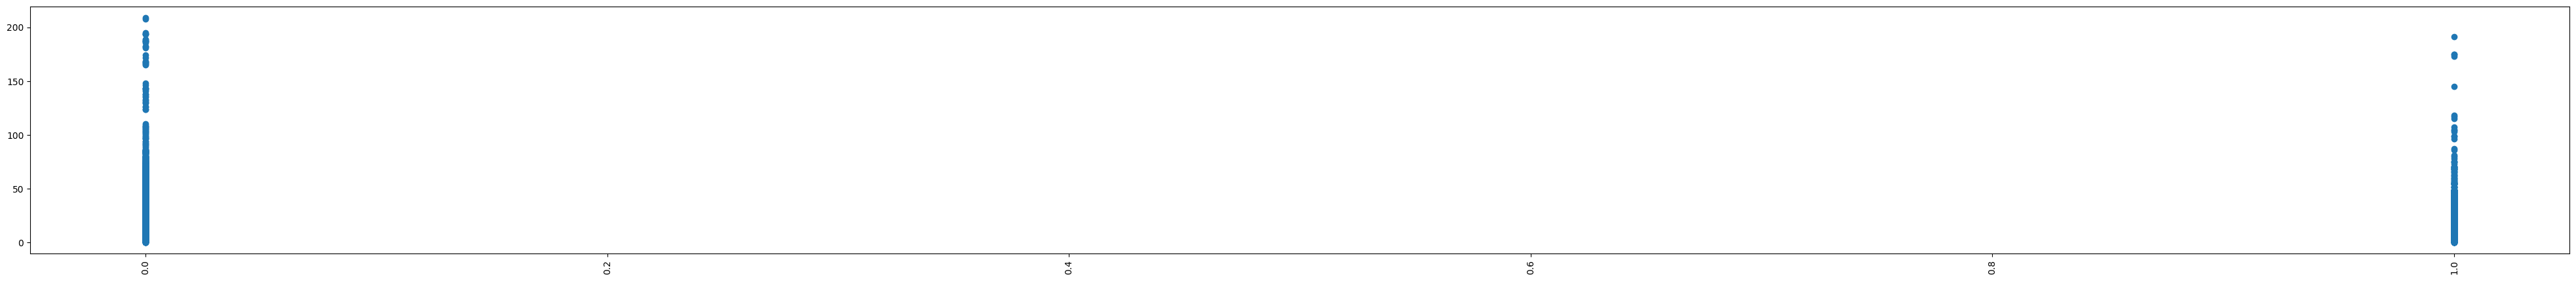

In [184]:
from matplotlib import pyplot as plt
#delivery_snapshot["Product_Category_Translation"].value_counts().sort_index().plot(kind='bar', rot=0, ylabel='count')
#plt.xticks(rotation=90)
#plt.rcParams['figure.figsize'] = [20, 5]
#plt.rcParams['figure.dpi'] = 100
#plt.show()

plt.scatter(delivery_snapshot['same_state'], delivery_snapshot['delivery_delay'])
plt.xticks(rotation=90)
plt.rcParams['figure.figsize'] = [50, 5]
plt.rcParams['figure.dpi'] = 100
plt.show()

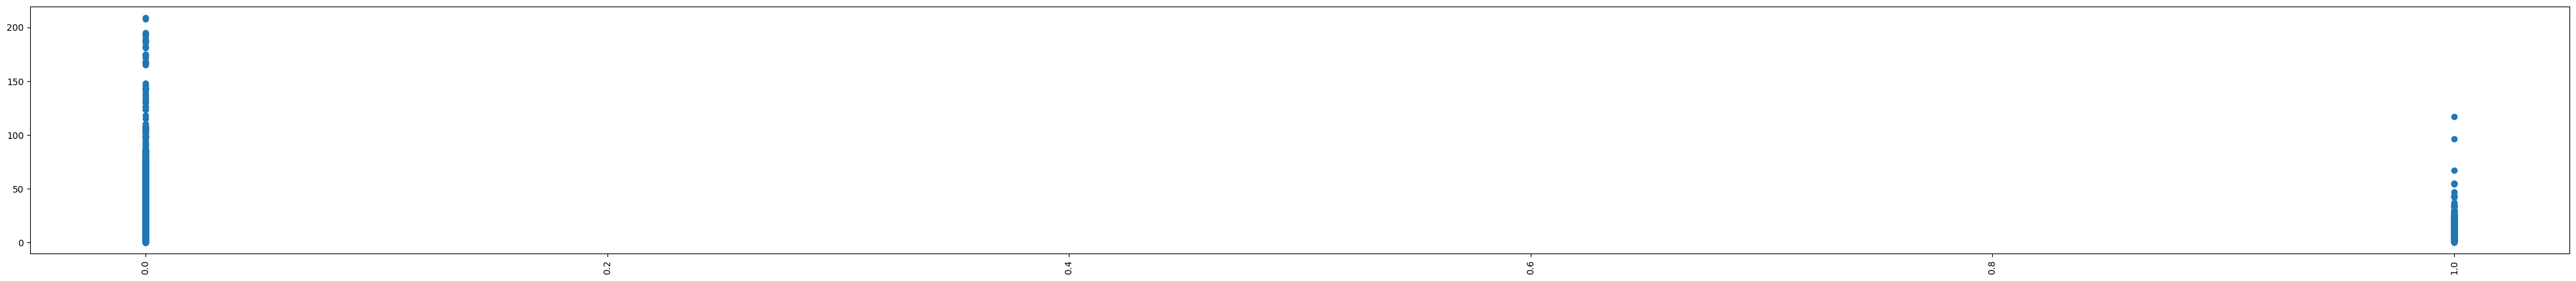

In [185]:
plt.scatter(delivery_snapshot['same_city'], delivery_snapshot['delivery_delay'])
plt.xticks(rotation=90)
plt.rcParams['figure.figsize'] = [50, 5]
plt.rcParams['figure.dpi'] = 100
plt.show()

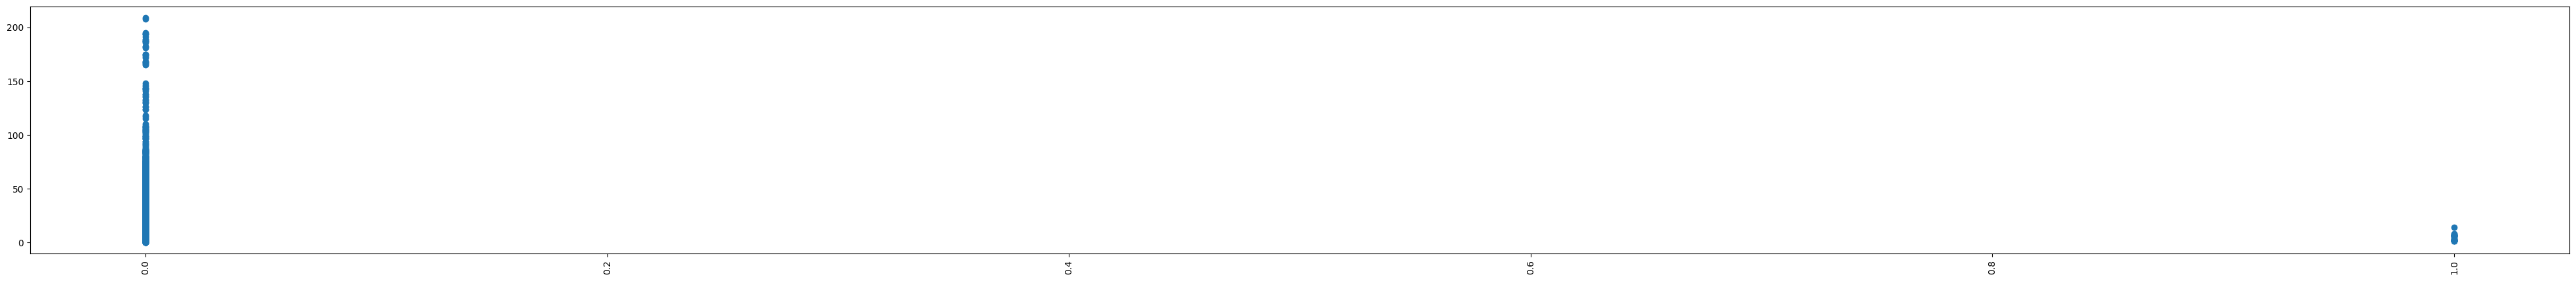

In [186]:
plt.scatter(delivery_snapshot['same_zipcode_prefix'], delivery_snapshot['delivery_delay'])
plt.xticks(rotation=90)
plt.rcParams['figure.figsize'] = [50, 5]
plt.rcParams['figure.dpi'] = 100
plt.show()

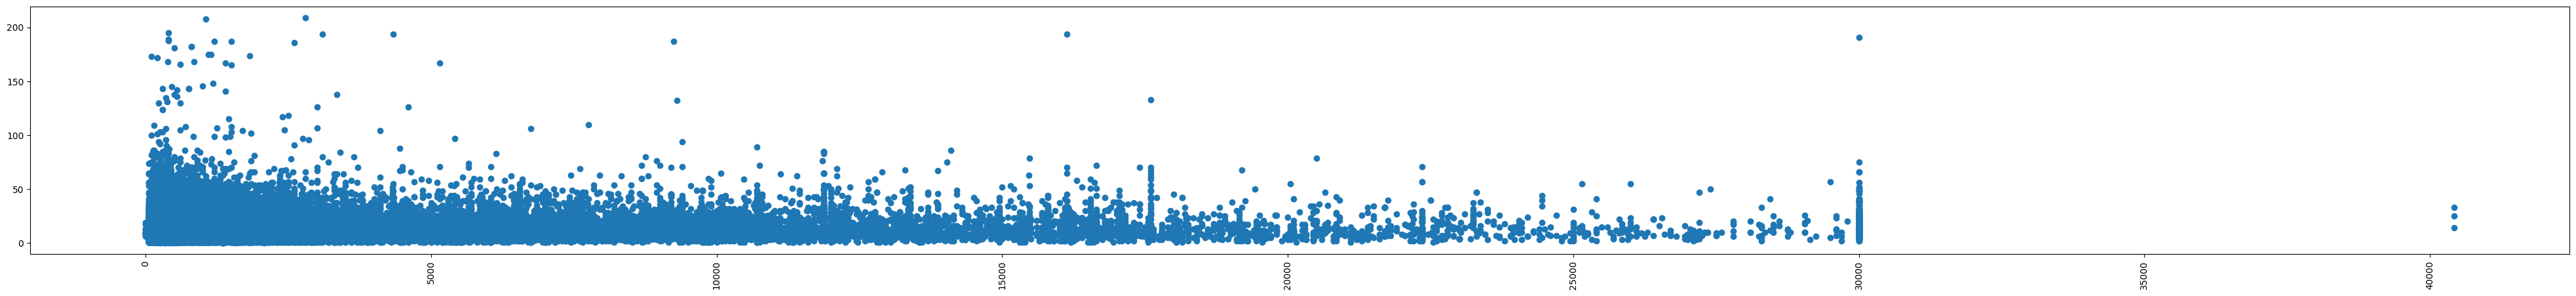

In [187]:
plt.scatter(delivery_snapshot['product_weight_g'], delivery_snapshot['delivery_delay'])
plt.xticks(rotation=90)
plt.rcParams['figure.figsize'] = [50, 5]
plt.rcParams['figure.dpi'] = 100
plt.show()

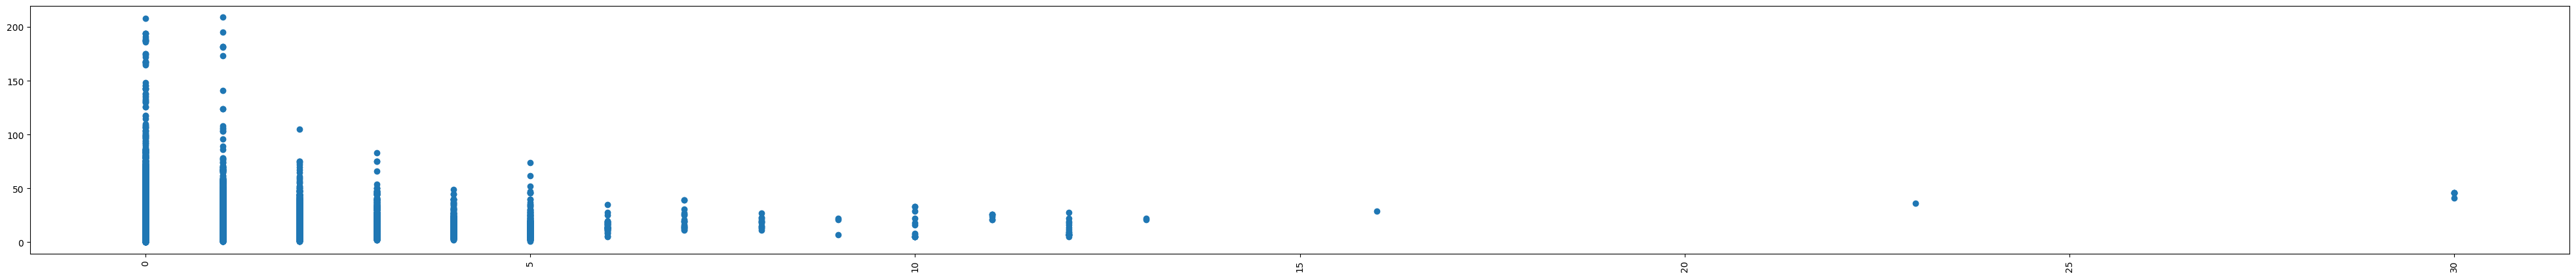

In [188]:
plt.scatter(delivery_snapshot['approval_time'], delivery_snapshot['delivery_delay'])
plt.xticks(rotation=90)
plt.rcParams['figure.figsize'] = [50, 5]
plt.rcParams['figure.dpi'] = 100
plt.show()

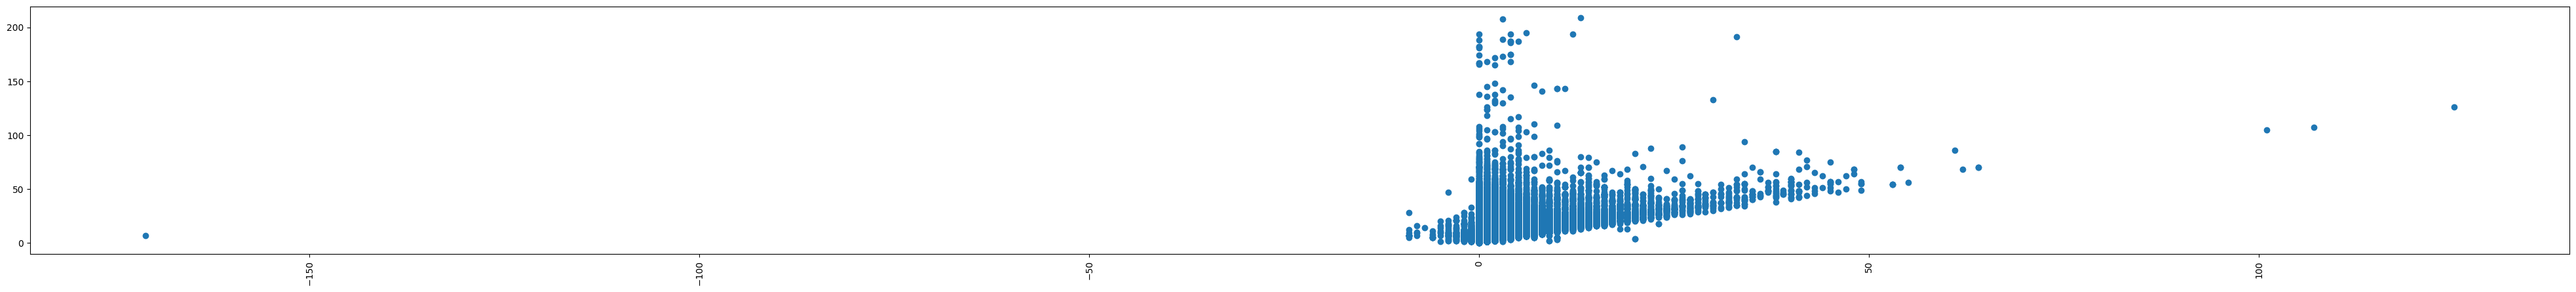

In [189]:
plt.scatter(delivery_snapshot['to_carrier_time'], delivery_snapshot['delivery_delay'])
plt.xticks(rotation=90)
plt.rcParams['figure.figsize'] = [50, 5]
plt.rcParams['figure.dpi'] = 100
plt.show()

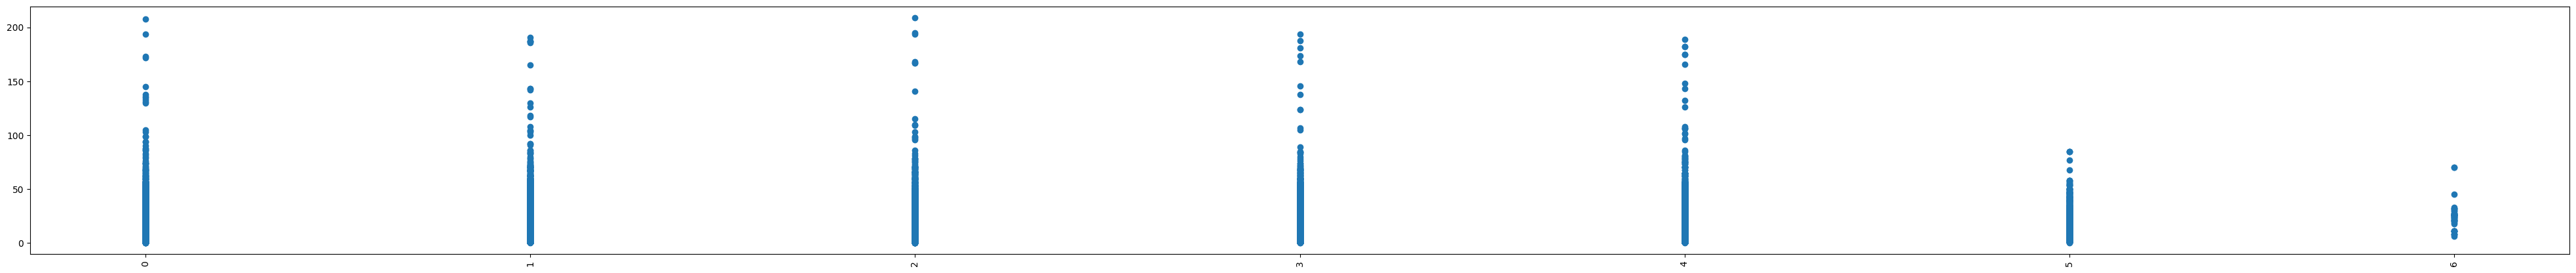

In [190]:
plt.scatter(delivery_snapshot['delivery_out_from_carrier_day_of_week'], delivery_snapshot['delivery_delay'])
plt.xticks(rotation=90)
plt.rcParams['figure.figsize'] = [50, 5]
plt.rcParams['figure.dpi'] = 100
plt.show()

FEATURE SELECTION: 

Feature selection is a technique in machine learning that allows us to select the most relevant features for predicting the target feature. The technique used below is FORWARD FEATURE SELECTION, in which, we begin with one feature and incrementally add more features, judging feature importance or relevance by its effect on the prediction scores. 

OBSERVATIONS: 

approval_time is not a very good predictor of delivery times. 
r2 score = 0.0073

to_carrier_time may be an important indicatory of delivery times (this follows common sense). 
r2 score = 0.166

delivery_out_from_carrier_day_of_week is not a very relevant feature, despite our initial assumption that it may have an effect. additionally, information may already be captured by to_carrier_time feature. 

same_city, same_state further boost r2 scores. This makes sense as it encodes distance information. 

MACHINE LEARNING MODEL: 

Dataset is split into train (80%) vs test (20%)

Since our features are numeric, we use a powerful regression tool in Random Forest in order to fit the training data and make predictions on test data. 

In [191]:
features = delivery_snapshot[['approval_time']]
X = features
y = delivery_snapshot['delivery_delay']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size = .80)

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

forest = RandomForestRegressor(n_estimators=10, random_state=42)
forest.fit(X_train, y_train)

forest_scores = cross_val_score(forest, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

from sklearn.metrics import r2_score
y_pred = forest.predict(X_test)
r2_score(y_test, y_pred)

0.0073667475025874785

In [192]:
features = delivery_snapshot[['approval_time', 'to_carrier_time']]
X = features
y = delivery_snapshot['delivery_delay']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size = .80)

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

forest = RandomForestRegressor(n_estimators=10, random_state=42)
forest.fit(X_train, y_train)

forest_scores = cross_val_score(forest, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

from sklearn.metrics import r2_score
y_pred = forest.predict(X_test)
r2_score(y_test, y_pred)

0.16678786540670776

In [193]:
features = delivery_snapshot[['approval_time', 'to_carrier_time', 'delivery_out_from_carrier_day_of_week']]
X = features
y = delivery_snapshot['delivery_delay']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size = .80)

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

forest = RandomForestRegressor(n_estimators=10, random_state=42)
forest.fit(X_train, y_train)

forest_scores = cross_val_score(forest, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

from sklearn.metrics import r2_score
y_pred = forest.predict(X_test)
r2_score(y_test, y_pred)

0.16704517347227898

In [194]:
features = delivery_snapshot[['approval_time', 'to_carrier_time', 'delivery_out_from_carrier_day_of_week', 'same_city']]
X = features
y = delivery_snapshot['delivery_delay']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size = .80)

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

forest = RandomForestRegressor(n_estimators=10, random_state=42)
forest.fit(X_train, y_train)

forest_scores = cross_val_score(forest, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

from sklearn.metrics import r2_score
y_pred = forest.predict(X_test)
r2_score(y_test, y_pred)

0.1911540080892582

In [195]:
features = delivery_snapshot[['approval_time', 'to_carrier_time', 'same_city', 'same_state']]
X = features
y = delivery_snapshot['delivery_delay']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size = .80)

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

forest = RandomForestRegressor(n_estimators=10, random_state=42)
forest.fit(X_train, y_train)

forest_scores = cross_val_score(forest, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

from sklearn.metrics import r2_score
y_pred = forest.predict(X_test)

r2_score(y_test, y_pred)

0.2922579016295179

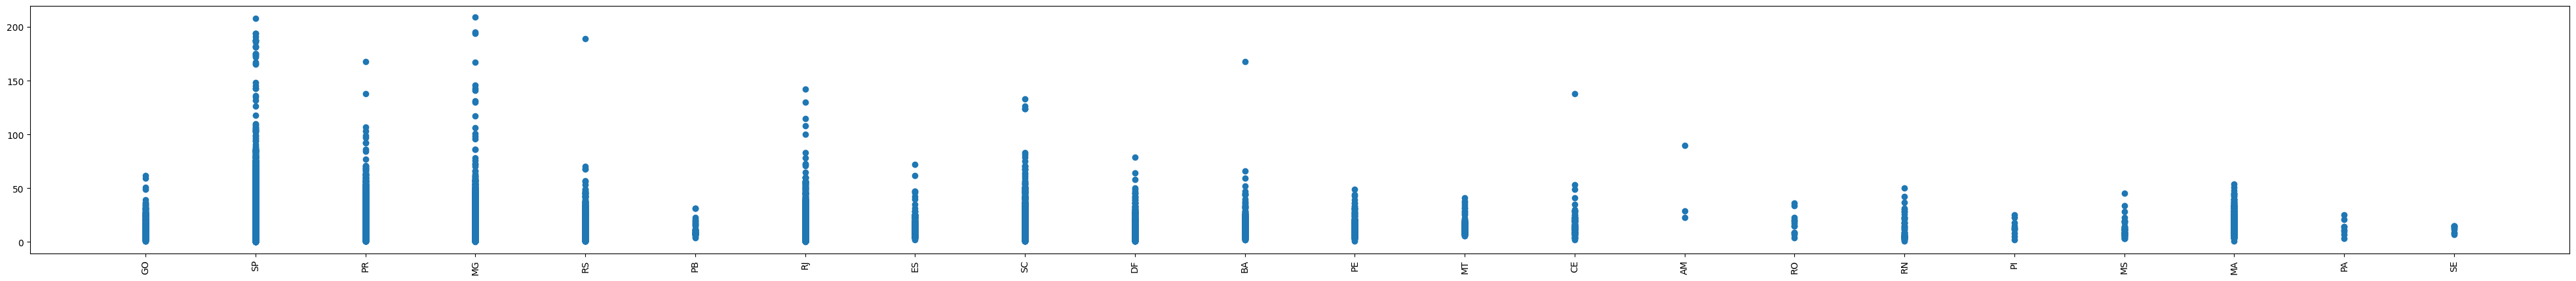

In [196]:
plt.scatter(delivery_snapshot['seller_state'], delivery_snapshot['delivery_delay'])
plt.xticks(rotation=90)
plt.rcParams['figure.figsize'] = [50, 5]
plt.rcParams['figure.dpi'] = 100
plt.show()

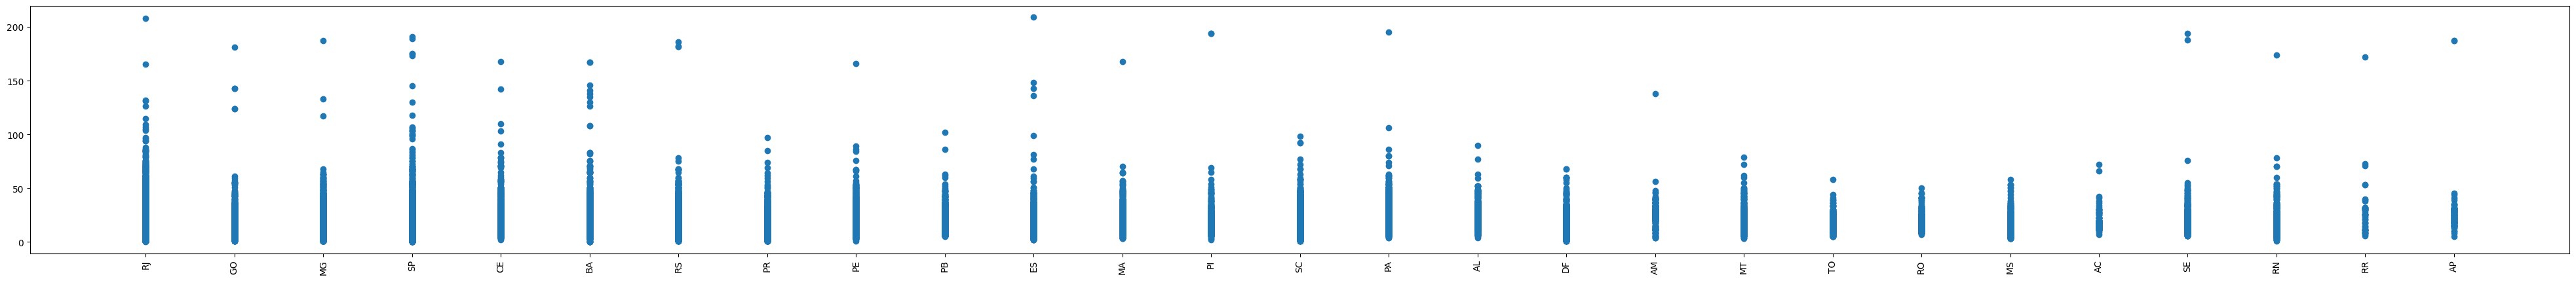

In [197]:
plt.scatter(delivery_snapshot['customer_state'], delivery_snapshot['delivery_delay'])
plt.xticks(rotation=90)
plt.rcParams['figure.figsize'] = [50, 5]
plt.rcParams['figure.dpi'] = 100
plt.show()

FEATURE ENGINEERING (NEXT STEPS' PERSPECTIVE): 

Though it is not covered as part of this project, there are improvements that can be made to our model which can help us better predict delivery times. For example, from the above plots, we can see that "seller_state" have certain states with higher delivery times than others. This can be important when trying to predict times especially in those states. Since this is a categorical feature, we would need to convert it using encoding techniques such as one hot encoding etc. and this would increase the dimensionality of our data set. 

We can also bring in other features such as product_length, product_height, product_width, payment_type, etc to see if they have an effect on delivery efficiencies. 

USER INTERFACE: 

The below form has been created within Colab and can be interacted with by an end user. This is for illustration purposes on how the "machine learning" model can interact with the "operational" aspect of a business. 

Please note - even though, delivery to carrier date is actually included in the overall delivery delay feature, I have included it because retail platforms often update estimated delivery dates in real-time and therefore predictions must be updated taking this information into information as events occur in real time. This kind of dynamic information resembles a business' operations. Other features such as seller and customer location will remain, for the most part, static. 

In [132]:
input_seller_state = 'GO' #@param ['GO', 'SP', 'PR', 'MG', 'RS', 'PB', 'RJ', 'ES', 'SC', 'DF', 'BA','PE', 'MT', 'CE', 'AM', 'RO', 'RN', 'PI', 'MS', 'MA', 'PA', 'SE']
input_customer_state = 'GO' #@param ['GO', 'SP', 'PR', 'MG', 'RS', 'PB', 'RJ', 'ES', 'SC', 'DF', 'BA','PE', 'MT', 'CE', 'AM', 'RO', 'RN', 'PI', 'MS', 'MA', 'PA', 'SE']

input_seller_city = 'goiania' #@param {type:"string"}
input_customer_city = 'ipatinga' #@param {type:"string"}

purchase_date = '2023-01-01' #@param {type:"date"}
approval_date = '2023-01-02'  #@param {type:"date"}
delivered_to_carrier_date = '2023-01-09'  #@param {type:"date"}

input_arrival_time = 1 #@param {type:"integer"}
input_to_carrier_time = 8  #@param {type:"integer"}


In [155]:
input_same_city = (input_seller_city == input_customer_city)
input_same_state = (input_seller_state == input_customer_state)

x_pred = [[input_arrival_time, input_to_carrier_time, input_same_city, input_same_state]]
x_pred_df = pd.DataFrame(x_pred, columns=['approval_time', 'to_carrier_time', 'same_city', 'same_state'])
print(x_pred_df)

y_pred_df = forest.predict(x_pred_df)
y_pred_df


   approval_time  to_carrier_time  same_city  same_state
0              1                8      False        True


array([14.08508905])